# Differential Evolution

Este algoritmo fue inventado por R. Storn y K. Price en 1997. Es un algoritmo que podemos usar como caja negra para optimizar funciones. Su principal ventaja es que no es necesario calcular derivadas. Este algoritmo ha ganado varios concursos de optimización.

Varios problemas de matemáticas se pueden traducir a encontrar el mínimo de una función real. También se usa en la vida real, por ejemplo, la Agencia Espacial Europea lo usa para encontrar el camino que debe seguir un vehículo espacial para alcanzar la órbita de un planeta usando poco combustible.

En realidad es un algoritmo genético, así que trabaja con poblaciones de candidatos a soluciones del problema. Aquí vamos a estar trabajando con funciones $f:[0,1]^n\to R$ y lo que queremos es minimizar $f$. Es fácil modificar el algoritmo para que considere funciones con otros dominios, incluso discretos.

Nota: Differential Evolution ya está implementado en SciPy y otros paquetes de python.

```
Input: una función f:R^n->R y valores para mut en [0.5,2], crossp en [0,1] y otros.
Crea una población aleatoria P de elementos en R^n.
While todavía no quieras que termine (tiempo, número de iteraciones, solución suficientemente buena, etc.):
    For x en P:
        Elige a,b,c en P (distintos de x y entre si).
        Calcula un nuevo y así:
            y = a+mut*(b-c)
            For i en {1,...,d}:
                Cambia la coord y_i por x_i con probabilidad crossp.
            Modifica y para que esté en el dominio.
        If f(y)<f(x) cambia a x por y.
Return el mejor x de P
```

In [1]:
import torch
from tqdm import tqdm

In [47]:
def DE(f, dim=1, pop_size=20, initial_pop = None, mut=0.8, crossp=0.7, its=200, proj_to_domain = lambda x : x):
    if initial_pop == None:
        P = torch.rand(pop_size, dim)
    else:
        P = initial_pop
        pop_size,dim = P.shape
        
    P = proj_to_domain(P)
    
    W = torch.ones(pop_size,pop_size).float()
    W[torch.arange(pop_size),torch.arange(pop_size)] = 0. # W lo necesitaremos después

    cost = f(P).squeeze()
    best_cost, best_index = torch.min(cost,dim=0)
    
    for it in tqdm(range(its)):
        I=torch.multinomial(W,3).T
        A,B,C = P[I]
        
        mutants = A + mut * (B - C)
        
        T = (torch.rand_like(P) < crossp).float()
        candidates = proj_to_domain(T*mutants + (1-T)*P)
        
        f_candidates = f(candidates).squeeze()
        
        S = (f_candidates < cost)[:,None].float()
        P = S*candidates + (1-S)*P
        cost = torch.min(f_candidates,cost)
        
        new_best_cost, new_best_index = torch.min(cost,dim=0)
        if new_best_cost < best_cost:
            best_cost = new_best_cost
            best_index = new_best_index
        
    return P[best_index], best_cost

In [9]:
def wrapper_for_f(f):
    return lambda P : torch.stack([f(p) for p in P])

Intentemos minimizar la función $g(x)=x(x-1)$. Ésta es una parábola que tiene su mínimo en $1/2$.

In [10]:
def g(x):
    return x*(x-1)

In [14]:
DE(g,1)

100%|██████████| 200/200 [00:00<00:00, 2533.29it/s]


(tensor([0.4999]), tensor(-0.2500))

Podemos jugar con los parámetros `mut`, `crossp`, `popsize` y `its`. Éstos controlan el el multiplicador para la mutación, la probabilidad con la que se modifica cada cordenada de un individuo, el tamaño de la población y el número de iteraciones, respectivamente.

In [21]:
DE(g, 1, mut=0.5, crossp=0.5, pop_size=60, its=20000)

100%|██████████| 20000/20000 [00:07<00:00, 2672.47it/s]


(tensor([0.5000]), tensor(-0.2500))

Ahora vamos a optimizar la función $f(x_0,x_1)=\sin(100 x_0 x_1)+10 (x_1-x_0)^2$ en $[0,1]\times[0,1]$.

¿Cuál será su valor mínimo?

In [22]:
def f(x):
    return torch.sin(100*x[:,0]*x[:,1]) + 10*(x[:,1]-x[:,0])**2

Así se ve la sección de la gráfica con $x_1=1/2$:

In [23]:
import matplotlib.pyplot as plt

X = torch.arange(0.0,1.0,0.002)[:,None]
Y = f(torch.cat((X,0.5*torch.ones_like(X)),dim=1))

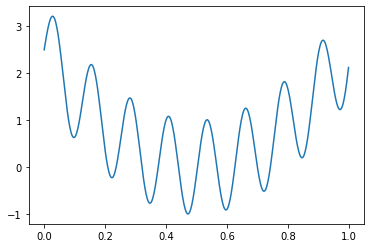

In [26]:
plt.plot(X,Y)
plt.show()

In [31]:
DE(f,2)

100%|██████████| 200/200 [00:00<00:00, 1905.97it/s]


(tensor([3.1211, 3.1154]), tensor(-0.9994))

Para que el algoritmo no nos de una solución fuera del cuadrado podemos decirle cómo regresarse al dominio si se sale. Ésto se hace con el parámetri `proj_to_domain`.

In [32]:
def clip(x):
    return torch.clamp(x,0.,1.)

In [34]:
DE(f,2, proj_to_domain = clip, its=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2116.70it/s]


(tensor([0.4854, 0.4854]), tensor(-1.))

Esta es otra forma en la que pudimos regresar al dominio, elegir una buena función puede afectar la eficiencia de la búsqueda.

In [35]:
def if_out_rand(x):
    x[x>1] = torch.rand_like(x[x>1])
    x[x<0] = torch.rand_like(x[x<0])
    return x

In [36]:
DE(f,2, proj_to_domain = if_out_rand)

100%|██████████| 200/200 [00:00<00:00, 1450.18it/s]


(tensor([0.3316, 0.3316]), tensor(-1.))

Digamos que ahora queremos el máximo en $[1,3]\times[1,3]$, entonces no queremos empezar con una población aleatoria en $[0,1]\times[0,1]$. Le podemos dar la población inicial con `initial_pop`. En este caso, `pop_size` es ignorado. No olviden que ahora queremos maximizar y no minimizar.

In [55]:
PI = torch.rand(60, 2)*2+1

def clip2(x):
    return torch.clamp(x,1,3)

def minus_f(x):
    return -f(x)

In [51]:
DE(minus_f,2, proj_to_domain = clip2,  initial_pop = PI ,its=500)

100%|██████████| 500/500 [00:00<00:00, 1859.89it/s]


(tensor([1.0101, 3.0000]), tensor(-40.5881))

In [70]:
DE(g,1,its=20000)

100%|██████████| 20000/20000 [00:06<00:00, 2984.45it/s]


(tensor([0.5000]), tensor(-0.2500))

In [71]:
DE(wrapper_for_f(g),its=20000)

100%|██████████| 20000/20000 [00:19<00:00, 1052.15it/s]


(tensor([0.5001]), tensor(-0.2500))

## Ejercicios

0. Juega con los parámetros de DE en los siguientes problemas para ver cómo efectan los resultados.

1. Minimiza $f(x_1,x_2)=(x_1^2+x_2-11)^2+(x_1+x_2^2-7)^2$ sujeto a $(x_1-5)^2+x_2^2\le 26$, $4x_1-x_2-20\le 0$ y $x_1,x_2\ge 0$.

2. En una feria encuentras este juego. Tienes que elegir 2 números $a,b$ en $[0,1]$. Después se hace lo siguiente $5$ veces: Cambias a $a,b$ por $ab,a+b$, pero si el nuevo $b$ es mayor que $1$ entonces a $b$ lo divides entre $2$ y a $a$ lo cambias por la parte fraccionaria de $3a+0.1$. Después de hacer esto 5 veces, si el valor de $a$ es al menos $0.99$ te ganas un premio. ¿Es posible ganar este juego?

3. Sea $h:\{1,\dots,1000\}^3 \to \mathbb R$ dada por $h(a,b,c)=GCD(a,b)-2*GCD(b,c)+3*GCD(a,c)$. Trata de encontrar su máximo. Pueden usar `import math` y `math.gcd()`.

4. Dado un triángulo $T$ en $[0,100]\times [0,100]$, se construye su bounding box $B$, i.e., el rectángulo más chico con lados paralelos a los ejes que contiene a $T$. ¿Si el área de $T$ es $1$, cuál es la menor área posible para $B$?

5. Hay un conjunto $X$ de $10$ puntos en el plano. Dado un punto $p$ se define $f(p)$ como la suma de las distancias de $p$ a los $3$ puntos más lejanos de $p$ en $X$. Encuentra el $p$ que minimiza a $f(p)$.

6. Intenta usar descenso por la gradiente para todas funciones anteriores y compara los resultados con los de DE.